In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/home/antoine/homhots/HOTS/HOTS


In [2]:
import os
import pickle
import datetime
from mix_Network import *
from tonic.transforms import AERtoVector

dataset = 'nmnist'
path = f'../Records/{dataset}/models/'
timestr = '2021-02-16'

%mkdir -p ../Records
#%mkdir -p ../Records/EXP_03_NMNIST

sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nb_train = 5000
nb_test = 1000
nblay = 3
nbclust = 4
filt = 2

ds = 50
nb_train_b = nb_train//ds
nb_test_b = nb_test//ds

In [3]:
def netparam(name, filt, tau, nblay, nbclust, sigma, homeinv, jitter):
    if name=='hots':
        homeo = False
        homeotest = False
        krnlinit = 'first'
        hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
        hotshom = hotshom.learning1by1()
    elif name=='homhots':
        homeo = True
        homeotest = True
        krnlinit = 'rdn'
        hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
        hotshom = hotshom.learningall()
    elif name=='onlyonline':
        homeo = False
        homeotest = False
        krnlinit = 'rdn'
        hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
        hotshom = hotshom.learningall()
    return hotshom, homeotest

def homadload(name):
    def getdigind(stream):
        t = np.array(stream[2])
        newdig = [0]
        for i in range(len(t)-1):
            if t[i]>t[i+1]:
                newdig.append(i)
        return newdig
        
    hotshom, homeotest = netparam(name, filt, tau, nblay, nbclust, sigma, homeinv, jitter)
    stream_train = hotshom.running(homeotest = homeotest, nb_digit=nb_train, LR=True)
    stream_test = hotshom.running(homeotest = homeotest, nb_digit=nb_test, LR=True)
    digind_train = getdigind(stream_train)
    digind_test = getdigind(stream_test)
    return stream_train, stream_test, digind_train, digind_test

def getvect(stream, digind, dignumber, transform, ordering = 'xytp', sensor_size=[34,34]):
    
    start = digind[dignumber]
    stop = digind[dignumber+1]
    events = np.zeros([stop-start,4])
    for var in range(4):
        events[:,var] = stream[var][start:stop]
    output = transform(events,sensor_size,ordering)
    plt.imshow(output)
    return output

In [4]:
#for name in ['onlyonline', 'homhots', 'hots']:
for name in ['homhots']:
    hotshom, homeotest = netparam(name, filt, tau, nblay, nbclust, sigma, homeinv, jitter)
    stream_train = hotshom.running(homeotest = homeotest, nb_digit=nb_train, LR=True)
    stream_test = hotshom.running(homeotest = homeotest, nb_digit=nb_test, LR=True)

2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False
../Records/nmnist/train/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_5000_[None, None]_homeo.pkl
../Records/nmnist/train/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_1000_[None, None]_homeo.pkl


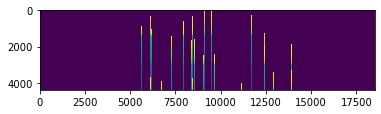

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, TensorDataset

import torchvision
import torchvision.transforms as transforms

events_train = np.zeros([len(stream_train[2]),4])
ordering = 'xytp'
for i in range(4):
    events_train[:,i] = stream_train[i][:]

In [23]:
#for name in ['onlyonline', 'homhots', 'hots']:
for name in ['homhots']:
    hotshom, homeotest = netparam(name, filt, tau, nblay, nbclust, sigma, homeinv, jitter)
    stream_train = hotshom.running(homeotest = homeotest, nb_digit=nb_train, LR=True)
    stream_test = hotshom.running(homeotest = homeotest, nb_digit=nb_test, LR=True)
    #JS_score = histoscore(histo_train, histo_test, verbose = True)
    #print(f'{JS_score=}')

2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False
../Records/nmnist/train/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_5000_[None, None]_homeo.pkl
../Records/nmnist/train/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_1000_[None, None]_homeo.pkl


# Performing logistic regression on raw input spikes

# Performing logistic regression on the network output
## With homeostasis